# Predicting Codon-based Traits Across Kingdoms

**Import Librarys**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score


In [ ]:
# Additional data to support analysis:
codon_key = pd.read_csv("codon_types.csv")
kingdom_names = pd.read_csv("kingdom_names.csv")

In [ ]:
codon_key

,Codon,AminoAcid,Letter,FullName,Type
0,AAA,Lys,K,Lysine,Basic
1,AAC,Asn,N,Asparagine,Polar
2,AAG,Lys,K,Lysine,Basic
3,AAU,Asn,N,Asparagine,Polar
4,ACA,Thr,T,Threonine,Polar
...,...,...,...,...,...
59,UGU,Cys,C,Cysteine,Polar
60,UUA,Leu,L,Leucine,Nonpolar
61,UUC,Phe,F,Phenylalanine,Nonpolar
62,UUG,Leu,L,Leucine,Nonpolar


**Load Data**

In [ ]:
codon = pd.read_csv("/content/codon_usage_Final.csv", low_memory=False)\
    .join(kingdom_names.set_index("Kingdom"), on="Kingdom")\
    .drop("Kingdom", axis=1)\
    .rename({"Kingdom_full":"Kingdom"}, axis=1)
print(codon.shape)

(13028, 69)


In [ ]:
codon.head()

,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,CUC,...,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA,Kingdom
0,0,100217,1995,Epizootic haematopoietic necrosis virus,0.01654,0.01203,0.00050,0.00351,0.01203,0.03208,...,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000,Virus
1,0,100220,1474,Bohle iridovirus,0.02714,0.01357,0.00068,0.00678,0.00407,0.02849,...,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000,Virus
2,0,100755,4862,Sweet potato leaf curl virus,0.01974,0.0218,0.01357,0.01543,0.00782,0.01111,...,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144,Virus
3,0,100880,1915,Northern cereal mosaic virus,0.01775,0.02245,0.01619,0.00992,0.01567,0.01358,...,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000,Virus
4,0,100887,22831,Soil-borne cereal mosaic virus,0.02816,0.01371,0.00767,0.03679,0.01380,0.00548,...,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131,Virus


In [ ]:
codon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13028 entries, 0 to 13027
Data columns (total 69 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DNAtype      13028 non-null  int64  
 1   SpeciesID    13028 non-null  int64  
 2   Ncodons      13028 non-null  int64  
 3   SpeciesName  13028 non-null  object 
 4   UUU          13028 non-null  object 
 5   UUC          13028 non-null  object 
 6   UUA          13028 non-null  float64
 7   UUG          13028 non-null  float64
 8   CUU          13028 non-null  float64
 9   CUC          13028 non-null  float64
 10  CUA          13028 non-null  float64
 11  CUG          13028 non-null  float64
 12  AUU          13028 non-null  float64
 13  AUC          13028 non-null  float64
 14  AUA          13028 non-null  float64
 15  AUG          13028 non-null  float64
 16  GUU          13028 non-null  float64
 17  GUC          13028 non-null  float64
 18  GUA          13028 non-null  float64
 19  GUG 

**Define X & Y**

In [ ]:
x= list(codon.columns[[len(x) == 3 for x in codon.columns]].values)
y= "Kingdom"
xy= x+ [y]

**Descriptive Statistics and Data Preprocessing**

In [ ]:
codon= codon[~codon['UUU'].str.contains('[A-Za-z]') & ~codon['UUC'].str.contains('[A-Za-z]')]
codon[["UUU","UUC"]] = codon[["UUU","UUC"]].astype(float)

<ipython-input-79-8f36004caccd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  codon[["UUU","UUC"]] = codon[["UUU","UUC"]].astype(float)


In [ ]:
# Add extra column for the log of Ncodons
codon['log_Ncodons'] = list(np.log10(codon.Ncodons.values))

<ipython-input-80-2c801a21c1af>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  codon['log_Ncodons'] = list(np.log10(codon.Ncodons.values))


In [ ]:
# There are no null values
codon.isnull().sum()

DNAtype        0
SpeciesID      0
Ncodons        0
SpeciesName    0
UUU            0
              ..
UAA            0
UAG            0
UGA            0
Kingdom        0
log_Ncodons    0
Length: 70, dtype: int64

In [ ]:
codon.shape

(13026, 70)

In [ ]:
# Shape of original data
print("Shape of Dataset: ", codon.shape)
print("Number of Input Columns: ", len(x))
print("Data Types of Inputs: ", set(codon[x].dtypes))

Shape of Dataset:  (13026, 70)
Number of Input Columns:  64
Data Types of Inputs:  {dtype('float64')}


**EDA**

Text(0.5, 0.98, 'Number of Codons by Kingdom')

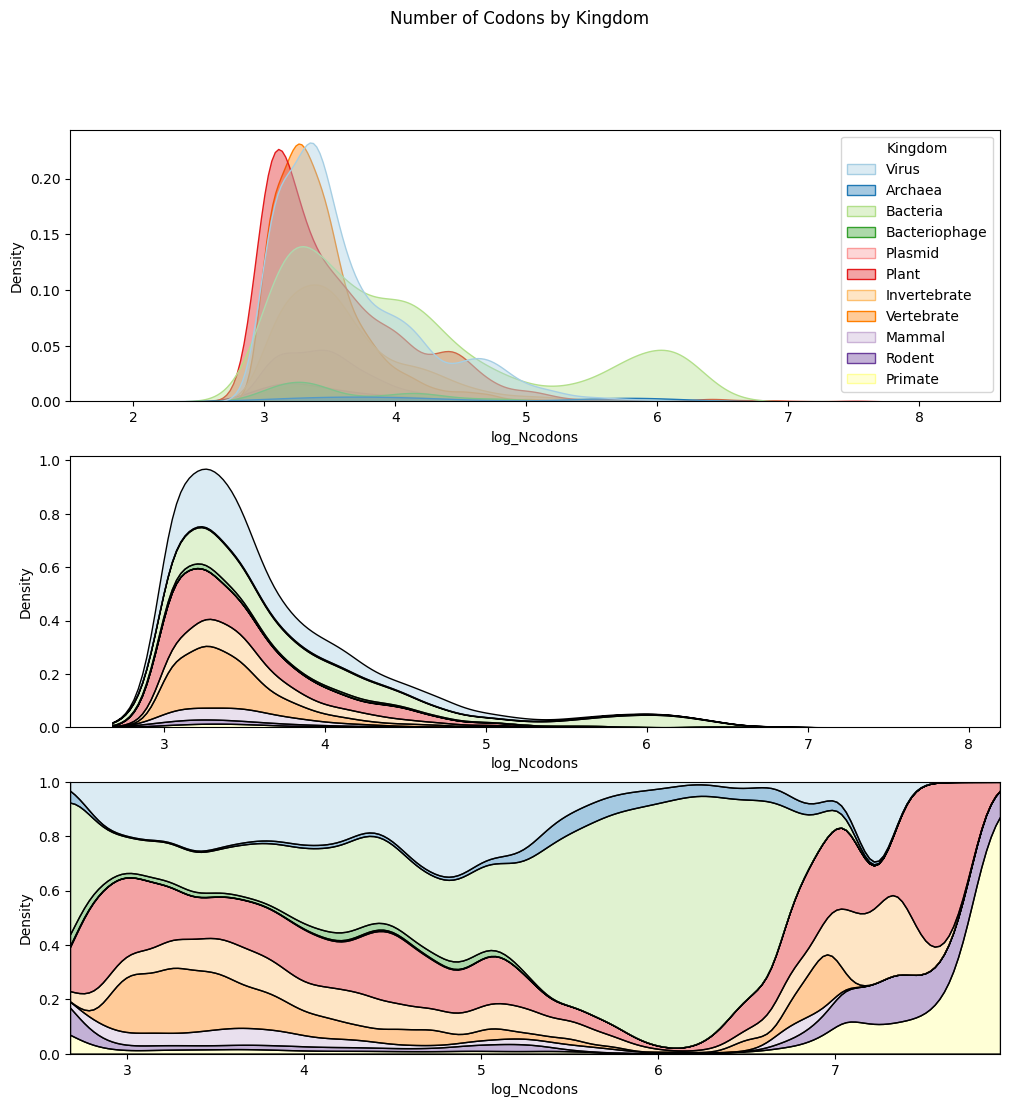

In [ ]:
# Number of codons per kingdom

fig, ax = plt.subplots(3,1,figsize=(12, 12))

sns.kdeplot(data=codon, x="log_Ncodons",
            hue="Kingdom", alpha = 0.4, linewidth=1, fill=True,
           palette = "Paired",
           ax=ax[0])

sns.kdeplot(data=codon, x="log_Ncodons",
            hue="Kingdom", alpha = 0.4, linewidth=1, fill=True, multiple="stack",
           palette = "Paired",
           ax=ax[1])
sns.kdeplot(data=codon, x="log_Ncodons",
            hue="Kingdom", alpha = 0.4, linewidth=1, fill=True, multiple="fill",
           palette = "Paired",
           ax=ax[2])


ax[1].get_legend().remove()
ax[2].get_legend().remove()
fig.suptitle("Number of Codons by Kingdom")

In [ ]:
# Long formatted data to make graphing easier
codon_long = pd.melt(codon[xy],
                    id_vars = "Kingdom",
                    var_name = "codon",
                    value_name = "freq")\
    .merge(codon_key, left_on='codon', right_on='Codon')

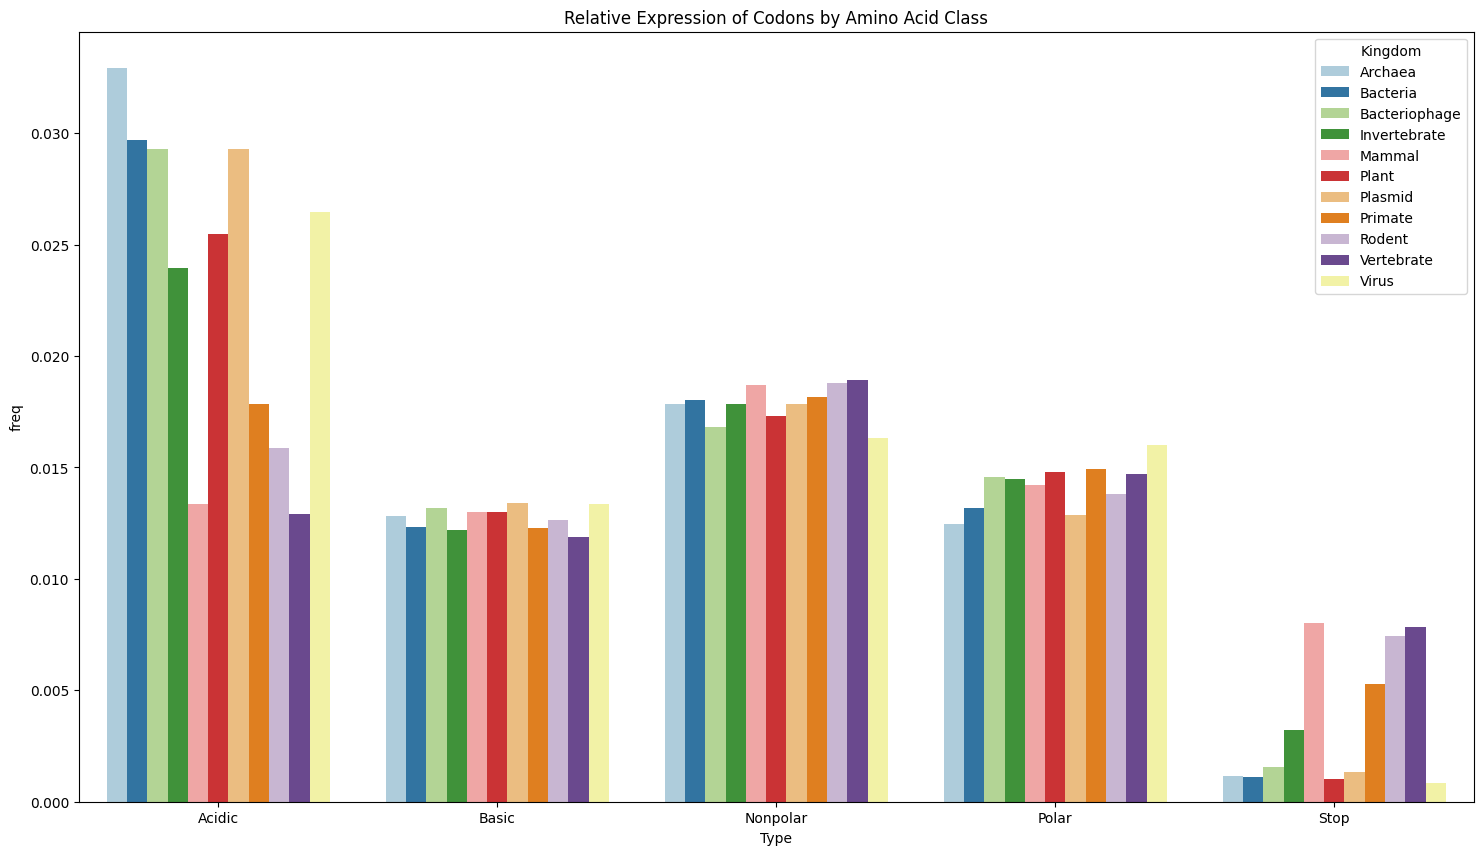

In [ ]:
grouped_codon_freq = codon_long[["Kingdom", "Type", "freq"]]\
    .groupby(["Kingdom", "Type"])\
    .mean()\
    .reset_index()

plt.figure(figsize=(18, 10))
sns.barplot(x = "Type", y="freq", hue="Kingdom", data=grouped_codon_freq, palette = "Paired")\
    .set_title("Relative Expression of Codons by Amino Acid Class")
plt.show()

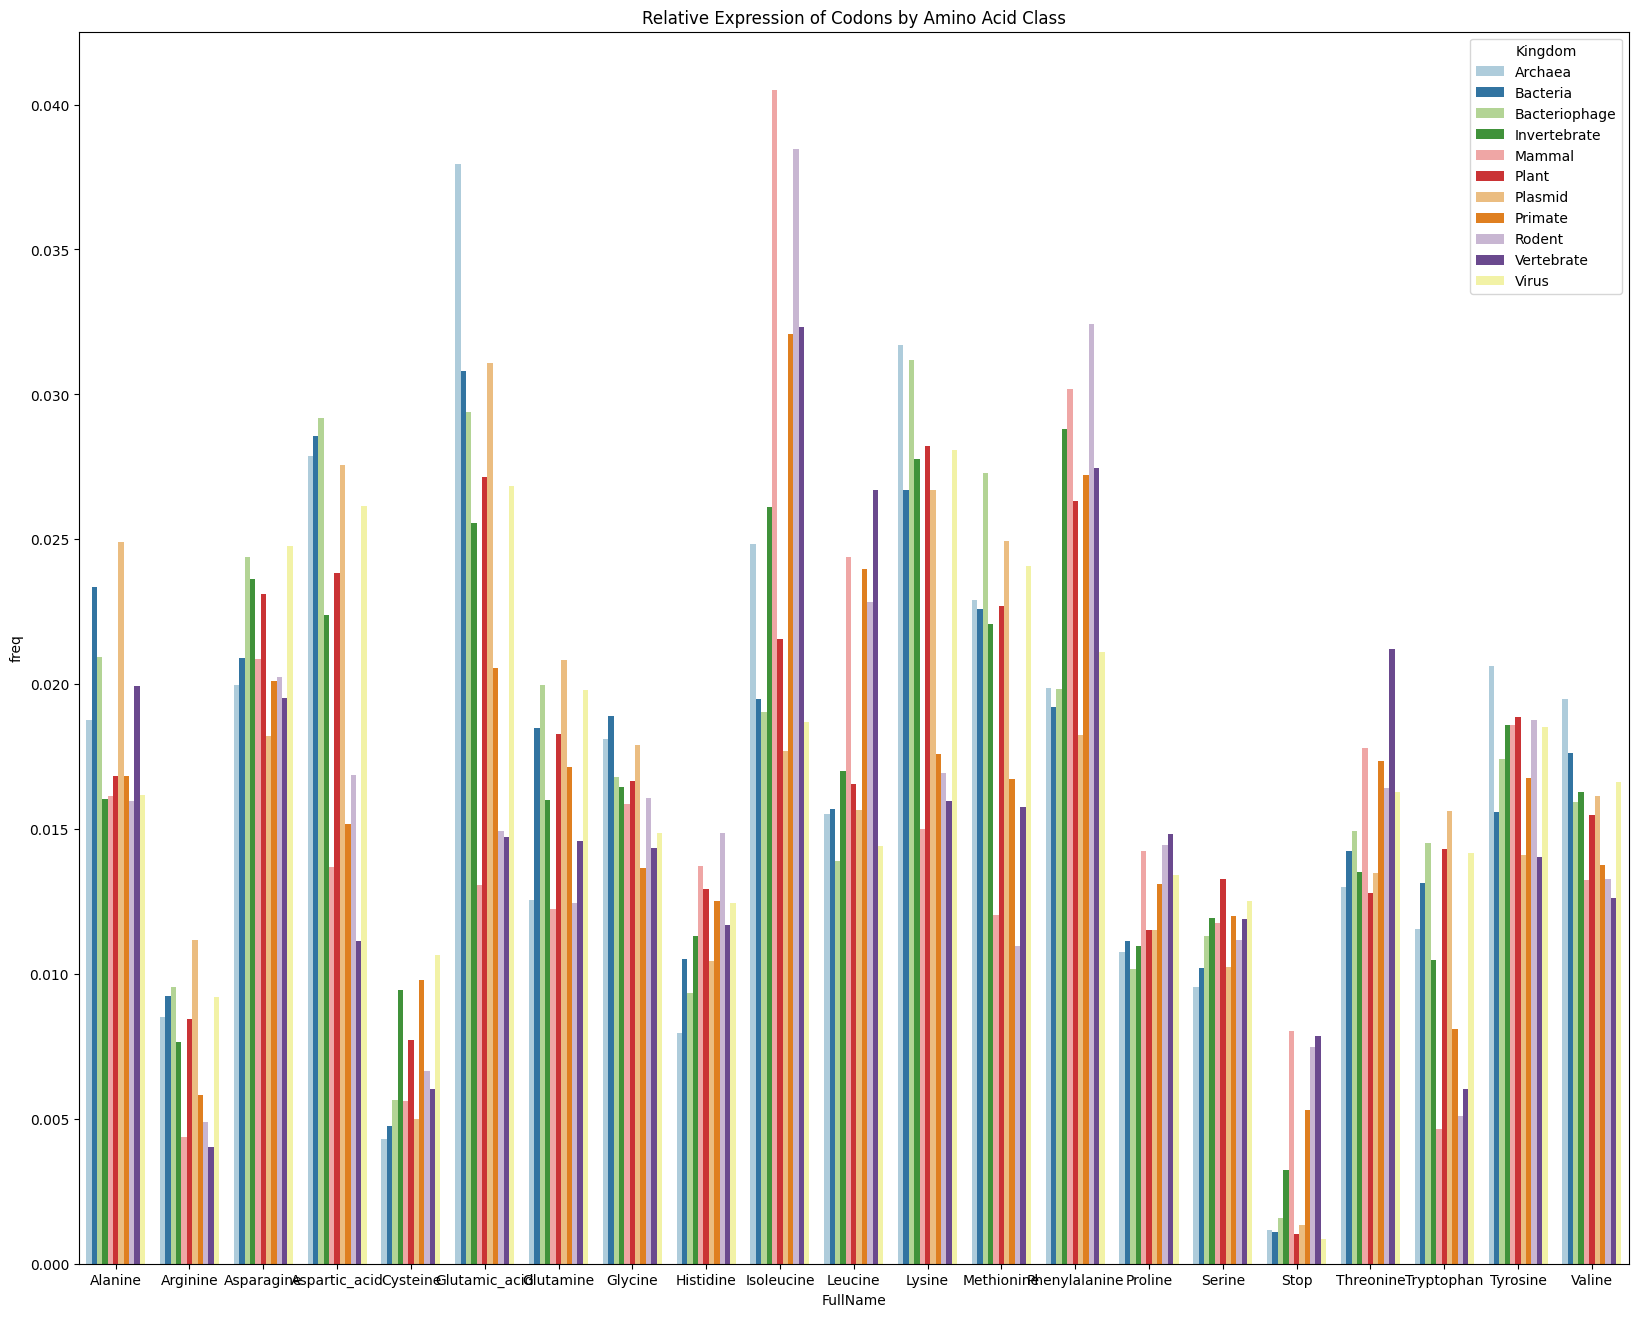

In [ ]:
# Individual codon frequency
grouped_codon_freq = codon_long[["Kingdom", "FullName", "freq"]]\
    .groupby(["Kingdom", "FullName"])\
    .mean()\
    .reset_index()

plt.figure(figsize=(20,16))
sns.barplot(x = "FullName", y="freq", hue="Kingdom", data=grouped_codon_freq, palette = "Paired")\
    .set_title("Relative Expression of Codons by Amino Acid Class")
plt.show()

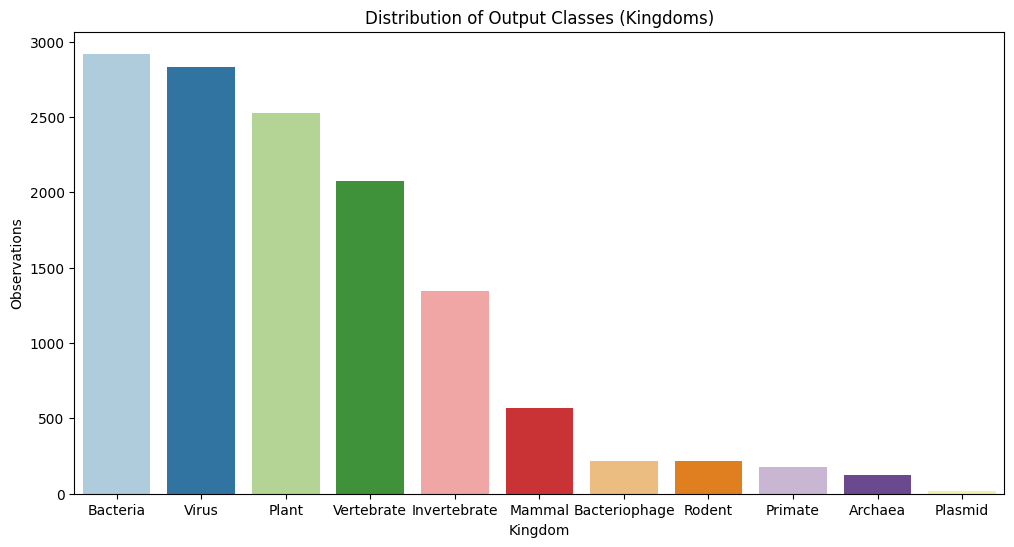

Post SMOTE Kingdom Distributions
Bacteria         2919
Virus            2831
Plant            2523
Vertebrate       2077
Invertebrate     1345
Mammal            572
Bacteriophage     220
Rodent            215
Primate           180
Archaea           126
Plasmid            18
Name: Kingdom, dtype: int64
(32109, 64)


In [ ]:
X = codon[x]
y = codon[y]

plt.figure(figsize=(12, 6))
sns.barplot(
    x="Kingdom",
    y="Observations",
    data=y.value_counts().reset_index().rename({"index":"Kingdom", "Kingdom":"Observations"}, axis=1),
    palette="Paired"
).set_title("Distribution of Output Classes (Kingdoms)")
plt.show()

X, y = SMOTE().fit_resample(X, y)

print("Post SMOTE Kingdom Distributions")
print(codon["Kingdom"].value_counts())
print(X.shape)

**Data Splitting**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)


print("Training Input Shape: ", X_train.shape)
print("Training Output Shape: ", y_train.shape)
print("Testing Input Shape: ", X_test.shape)
print("Testing Output Shape: ", y_test.shape)


Training Input Shape:  (21513, 64)
Training Output Shape:  (21513,)
Testing Input Shape:  (10596, 64)
Testing Output Shape:  (10596,)


**Decision Tree model and performance**

In [ ]:
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train, y_train)
y_pred = dt_classifier.predict(X_test)
dt_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", dt_accuracy)
dt_class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(dt_class_report)

Accuracy: 0.8884484711211778
Classification Report:
               precision    recall  f1-score   support

      Archaea       0.96      0.98      0.97       960
     Bacteria       0.82      0.77      0.79      1003
Bacteriophage       0.92      0.96      0.94       988
 Invertebrate       0.78      0.82      0.80       927
       Mammal       0.92      0.93      0.92       962
        Plant       0.80      0.76      0.78       953
      Plasmid       0.97      0.99      0.98       963
      Primate       0.95      0.95      0.95       932
       Rodent       0.93      0.96      0.94       928
   Vertebrate       0.90      0.88      0.89      1001
        Virus       0.82      0.78      0.80       979

     accuracy                           0.89     10596
    macro avg       0.89      0.89      0.89     10596
 weighted avg       0.89      0.89      0.89     10596



**Random Forest model and performance**

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", rf_accuracy)
rf_class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(rf_class_report)

Accuracy: 0.9761230653076632
Classification Report:
               precision    recall  f1-score   support

      Archaea       0.99      1.00      1.00       960
     Bacteria       0.95      0.96      0.96      1003
Bacteriophage       0.99      0.99      0.99       988
 Invertebrate       0.94      0.95      0.95       927
       Mammal       0.99      0.99      0.99       962
        Plant       0.96      0.93      0.94       953
      Plasmid       1.00      1.00      1.00       963
      Primate       1.00      0.99      0.99       932
       Rodent       0.99      0.99      0.99       928
   Vertebrate       0.99      0.96      0.98      1001
        Virus       0.94      0.96      0.95       979

     accuracy                           0.98     10596
    macro avg       0.98      0.98      0.98     10596
 weighted avg       0.98      0.98      0.98     10596



**KNN model and performance**

In [ ]:
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(X_train, y_train)
y_pred = knn_classifier.predict(X_test)
knn_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", knn_accuracy)
knn_class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(knn_class_report)

Accuracy: 0.9672517931294828
Classification Report:
               precision    recall  f1-score   support

      Archaea       0.98      1.00      0.99       960
     Bacteria       0.97      0.88      0.92      1003
Bacteriophage       0.95      1.00      0.97       988
 Invertebrate       0.91      0.96      0.94       927
       Mammal       0.98      0.99      0.99       962
        Plant       0.95      0.94      0.94       953
      Plasmid       0.96      1.00      0.98       963
      Primate       0.99      1.00      0.99       932
       Rodent       0.98      1.00      0.99       928
   Vertebrate       0.99      0.95      0.97      1001
        Virus       0.98      0.92      0.95       979

     accuracy                           0.97     10596
    macro avg       0.97      0.97      0.97     10596
 weighted avg       0.97      0.97      0.97     10596



**SVM model and performance**

In [ ]:
svm_classifier = SVC(kernel='poly')
svm_classifier.fit(X_train, y_train)
y_pred = svm_classifier.predict(X_test)
svm_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", svm_accuracy)
svm_class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(svm_class_report)

Accuracy: 0.9711211778029445
Classification Report:
               precision    recall  f1-score   support

      Archaea       0.99      1.00      1.00       960
     Bacteria       0.96      0.94      0.95      1003
Bacteriophage       0.96      0.98      0.97       988
 Invertebrate       0.94      0.96      0.95       927
       Mammal       0.99      0.97      0.98       962
        Plant       0.97      0.91      0.94       953
      Plasmid       0.99      1.00      1.00       963
      Primate       0.98      0.99      0.99       932
       Rodent       0.97      0.99      0.98       928
   Vertebrate       0.99      0.98      0.98      1001
        Virus       0.95      0.96      0.96       979

     accuracy                           0.97     10596
    macro avg       0.97      0.97      0.97     10596
 weighted avg       0.97      0.97      0.97     10596



**XG Boosting**

In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded=label_encoder.fit_transform(y_train)
y_test_encoded=label_encoder.fit_transform(y_test)

In [ ]:
xg_model=XGBClassifier(learning_rate= 0.5, n_estimators= 500)
xg_model.fit(X_train,y_train_encoded)
y_pred=xg_model.predict(X_test)
y_pred_decoded = label_encoder.inverse_transform(y_pred)
xgb_accuracy = accuracy_score(y_test, y_pred_decoded)
print("Accuracy:", xgb_accuracy)
xgb_class_report = classification_report(y_test, y_pred_decoded)
print("Classification Report:")
print(xgb_class_report)


Accuracy: 0.9785768214420536
Classification Report:
               precision    recall  f1-score   support

      Archaea       0.99      1.00      0.99       960
     Bacteria       0.98      0.95      0.96      1003
Bacteriophage       0.98      1.00      0.99       988
 Invertebrate       0.94      0.96      0.95       927
       Mammal       0.99      0.98      0.98       962
        Plant       0.96      0.94      0.95       953
      Plasmid       1.00      1.00      1.00       963
      Primate       1.00      1.00      1.00       932
       Rodent       0.99      1.00      0.99       928
   Vertebrate       0.99      0.98      0.98      1001
        Virus       0.96      0.97      0.96       979

     accuracy                           0.98     10596
    macro avg       0.98      0.98      0.98     10596
 weighted avg       0.98      0.98      0.98     10596



**RESULTS**

In [ ]:
dt_accuracy
dt_class_report
rf_accuracy
rf_class_report
knn_accuracy
knn_class_report
svm_accuracy
svm_class_report
xgb_accuracy
xgb_class_report

'               precision    recall  f1-score   support\n\n      Archaea       0.99      1.00      0.99       960\n     Bacteria       0.98      0.95      0.96      1003\nBacteriophage       0.98      1.00      0.99       988\n Invertebrate       0.94      0.96      0.95       927\n       Mammal       0.99      0.98      0.98       962\n        Plant       0.96      0.94      0.95       953\n      Plasmid       1.00      1.00      1.00       963\n      Primate       1.00      1.00      1.00       932\n       Rodent       0.99      1.00      0.99       928\n   Vertebrate       0.99      0.98      0.98      1001\n        Virus       0.96      0.97      0.96       979\n\n     accuracy                           0.98     10596\n    macro avg       0.98      0.98      0.98     10596\n weighted avg       0.98      0.98      0.98     10596\n'

In [ ]:
model_list=["Decision Tree","Rand_Forest","KNN","SVM","Xg Boosting"]
accu_score=[dt_accuracy,rf_accuracy,knn_accuracy,svm_accuracy,xgb_accuracy]
result_df=pd.DataFrame({"Model":model_list,
                        "Acc_Score":accu_score})

In [ ]:
result_df

,Model,Acc_Score
0,Decision Tree,0.888448
1,Rand_Forest,0.976123
2,KNN,0.967252
3,SVM,0.971121
4,Xg Boosting,0.978577


Text(0.5, 1.0, 'Accuracy of Oversampled Models by Model Type')

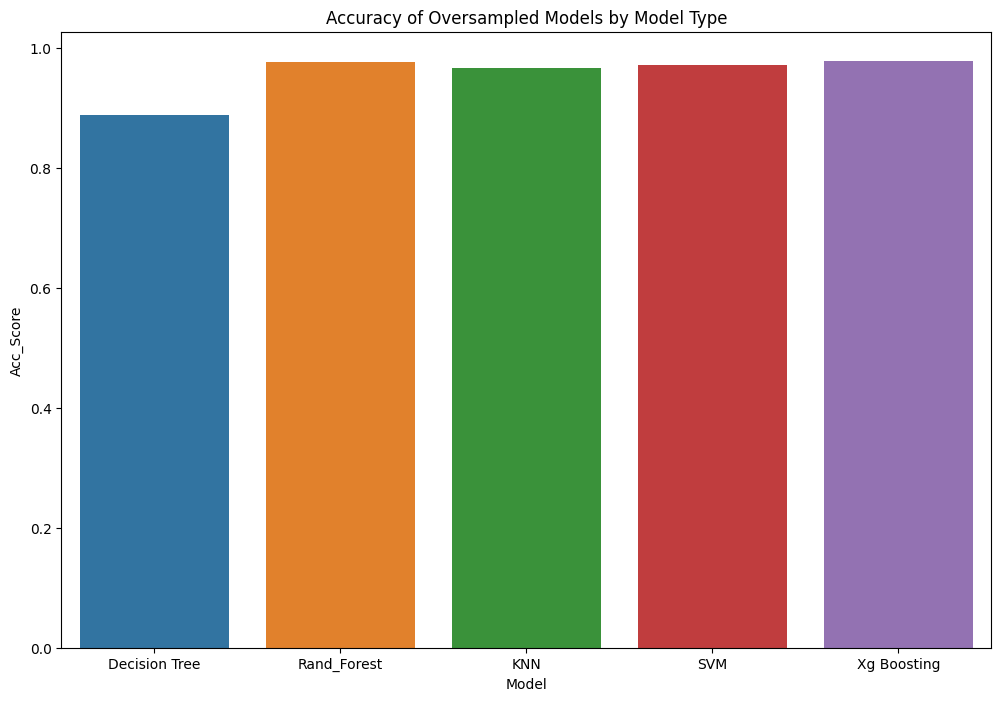

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(x="Model", y="Acc_Score", data=result_df).set_title("Accuracy of Oversampled Models by Model Type")